In [3]:
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score
from xml.dom.minidom import parse, parseString
from nltk import tokenize as tk
import nltk
import numpy as np
import unicodedata
import re
import os
import csv

class Question(object):
    def __init__(self, q_id, q, a_ids, a, r, s, l):
        self.question_id = q_id
        self.question = q
        self.answer_ids = a_ids
        self.answers = a
        self.reference_rank = r
        self.system_rank = s
        self.labels = l
    
    def __str__(self):
        return f"{self.question}\n  {self.answers}\n  {self.reference_rank}\n  {self.system_rank}\n  {self.labels}"
    
    def __repr__(self):
        return str(self)

class QuestionsAndAnswers(list):
    def __init__(self, dataset='Train'):
        ''' dataset = {Train,Test,Validation} '''
        list.__init__(self)
        self.PATH = 'MEDIQA2019_datasets/MEDIQA_Task3_QA/'
        p = self.read_dataset(dataset)
        self.extend(self.read_dataset(dataset))
        
        self.references = [np.array(q.reference_rank) for q in self]
        self.labels = [np.array(q.labels) for q in self]


    def preprocess_text(self, text):
        s = unicodedata.normalize("NFKD", text.lower())
        return re.sub(r'\[\d\]', '', s)

    def get_answers(self, answers):
        # return np.array((map(lambda ans: preprocess_text(ans.getElementsByTagName('AnswerText')[0].firstChild.nodeValue), answers)))
        answs, answs_ids, rank, chiqa, y = [], [], [], [], []
        for answer in answers:
            ans = self.preprocess_text(answer.getElementsByTagName('AnswerText')[0].firstChild.nodeValue)
            a_id = answer.getAttribute('AID')
            reference = int(answer.getAttribute('ReferenceRank'))
            system = int(answer.getAttribute('SystemRank'))
            label = answer.getAttribute('ReferenceScore')
            answs.append(ans); answs_ids.append(a_id); rank.append(reference); chiqa.append(system); y.append(int(label in ['3','4']))
        return answs, answs_ids, rank, chiqa, y
    
    def get_system_ranks(self):
          return [q.system_rank for q in self]
        
    def get_reference_ranks(self):
          return [q.reference_rank for q in self]
        
    def get_labels(self):
          return [q.labels for q in self]

    def read_dataset(self, dataset='Train'):
        i = 0
        indx2id = []
        QA, QA2 = [], []  # QA2 has also system ranks from ChiQA
        if dataset == 'Test': dataset = 'TestSet-wLabels'
        for filename in os.listdir(self.PATH):
            if not filename.endswith('.xml') or dataset not in filename: continue
            tree = parse(self.PATH + filename)
            questions = tree.getElementsByTagName('Question')
            for question in questions:
                qelem = question.getElementsByTagName('QuestionText')
                q, q_id = self.preprocess_text(qelem[0].firstChild.nodeValue), question.getAttribute('QID')
                # print(q) # --> questions
                answers = question.getElementsByTagName('Answer')
                answers_list, a_ids, rank, system, labels = self.get_answers(answers)
                QA.append([q,answers_list, rank, labels])
                question = Question(q_id=q_id, q=q, a_ids=a_ids, a=answers_list, r=rank, s=system, l=labels)
                # QA2.append([q,answers_list, rank, system, labels])
                QA2.append(question)
                indx2id.append(q_id); i+=1;
                # break
        return QA2

    def output_predictions(self, predictions, labels, file=''):
        assert len(predictions) == len(self)
        print('question_id,answer_id,label')
        with open(f'task3/sample_submission_round_2_{file}.csv', mode='w') as csv_file:
            for i, p in enumerate(predictions):
                q_id = self[i].question_id
                answers = self[i].answer_ids
                assert len(p) == len(answers), f'{len(p)} != {len(answers)}'
                # order = np.array(a)[np.argsort(p)]
                p = self.normalize_sequence(p)
                order = np.array(answers)[np.argsort(p)]
                # order = np.array(answers)[np.array(p)-1]
                lab = labels[i]
                ordered_lab = np.array(lab)[np.argsort(p)]
                if file == '':
                    
                    for a_id, l in zip(order,ordered_lab):
                        print(f"{q_id},{a_id},{int(l)}")
                else:
                    for a_id, l in zip(order,ordered_lab):
                        csv_file.write(f"{q_id},{a_id},{int(l)}\n")
            
    def normalize_sequence(self, seq):
        seq = np.array(seq)
        a = np.argsort(seq)
        seq[a] = list(range(1,len(seq)+1))
        return seq

    def accuracy(self, predictions):
        preds = np.concatenate(predictions)
        true  = np.concatenate(self.labels) 
        assert len(preds) == len(true), f"{len(preds)}, {len(true)}"
        return accuracy_score(true, preds)

    def precision(self, predictions):
        precisions = []
        num_answers = []
        for i in range(len(predictions)):
            labels = self.labels[i]
            p = self.normalize_sequence([x for j,x in enumerate(predictions[i]) if labels[j]==1])
            r = self.normalize_sequence([x for j,x in enumerate(self.references[i]) if labels[j]==1])
            if len(p) == 0:
                print(predictions[i])
            correct = sum([a == b for a,b in zip(p, r)])
            # for a,b in zip(p, r)
            # num_answers.append(len(p))
            precisions.append(correct/len(p))
        return np.mean(precisions)
        # return np.average(np.array(precisions), weights=num_answers)

    def mean_spearmanr(self, predictions):
        assert len(predictions) == len(self.references)
        count, total = 0, 0
        preds, refs = [], []
        for i in range(len(predictions)):
            labels = self.labels[i]
            assert len(predictions[i]) == len(labels), f"{predictions}, {labels}"
            p = [x for j,x in enumerate(predictions[i]) if labels[j]==1]
            r = [x for j,x in enumerate(self.references[i]) if labels[j]==1]
            preds += p; refs += r
            if len(r) == 1:
                total += 1
                count += 1
            elif len(r) == 0:
                continue
            else:
                total += 1
                count += spearmanr(p, r)[0]
        return spearmanr(preds, refs)[0]
        # return count/total

    def mean_reciprocal_rank(self, predicted):
        rs = []
        for k, (a, b) in enumerate(zip(predicted, self.references)):
            res = np.array(a)[np.argsort(b)]
            labels = self[k].labels
            res = [r if labels[i]==1 else 100 for i,r in enumerate(res)]
            rs.append([int(i==min(res)) for i in res])  # sets 1 in first ranked answer
        rs = (np.asarray(r).nonzero()[0] for r in rs)
        return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])
    
    

In [4]:
QA = QuestionsAndAnswers(dataset = 'Train')
QA_val = QuestionsAndAnswers(dataset = 'Validation')
QA_test = QuestionsAndAnswers(dataset = 'Test') 

In [6]:
len(QA_test)

150

In [3]:
system_ranks = QA_test.get_system_ranks()
reference_ranks = [q.reference_rank for q in QA_test]
labels = [q.labels for q in QA_test]
system_labels = [np.ones(len(l)) for l in labels]

In [4]:
# QA.output_predictions(reference_ranks, labels)
# QA.output_predictions(system_ranks, system_labels)

In [5]:
QA_test.output_predictions(system_ranks, system_labels, file='test2')

question_id,answer_id,label


In [6]:
import evaluator

def evaluate(filename):
    for task in [3]:
        print(f"Testing Task (Round-2) : {task}")
        answer_file_path = f"task{task}/ground_truth_round_2.csv"
        _client_payload = {}
        _client_payload["submission_file_path"] = f"task{task}/sample_submission_round_2_{filename}.csv"

        # Instaiate a dummy context
        _context = {}
        # Instantiate an evaluator
        aicrowd_evaluator = evaluator.MediqaEvaluator(answer_file_path, task=task, round=2)
        # Evaluate
        result = aicrowd_evaluator._evaluate(_client_payload, _context)
        print(result)

evaluate('test2')

Testing Task (Round-2) : 3
Ground truth: task3/ground_truth_round_2.csv
Submission file: task3/sample_submission_round_2_test2.csv
{'score_acc': 0.5167118337850045, 'score_secondary_spearman': 0.3149635036496349, 'meta': {'MRR': 0.895, 'Precision': 0.5167118337850045}}


Baseline

Testing Task (Round-2) : 3
{'score_acc': 0.5167118337850045, 'score_secondary_spearman': 0.3149635036496349, 'meta': {'MRR': 0.895, 'Precision': 0.5167118337850045}}

# Models

#### BioBERT

In [7]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
# % matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
# tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-large-cased-v1.1")
# tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")


# model = BertModel.from_pretrained('dmis-lab/biobert-large-cased-v1.1',
#                                   output_hidden_states = True, # Whether the model returns all hidden-states.
#                                   )

#### Train and test Datasets

In [9]:
sentences = [[q.question, a]  for q in QA for a in q.answers]
flatten   = lambda t: [item for sublist in t for item in sublist]
labels    = flatten([q.labels for q in QA])

sentences_test = [[q.question, a]  for q in QA_test for a in q.answers]
labels_test    = flatten([q.labels for q in QA_test]) 

In [10]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

BATCH_SIZE = 8
BATCH_SIZE_TEST = 64
max_len_seq = 512

class MEDIQA_Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = []
        self.y = np.array(y)
        for q, a in X:
            _q = tokenizer.convert_tokens_to_ids(tokenizer.tokenize("[CLS] " + q + " [SEP]"))[:max_len_seq]
            _q += [0]*(max_len_seq-len(_q))
            _a = tokenizer.convert_tokens_to_ids(tokenizer.tokenize("[CLS] " + a + " [SEP]"))[:max_len_seq]
            _a += [0]*(max_len_seq-len(_a))
            self.X.append([_q, _a])
        self.X = np.array(self.X)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        score = torch.FloatTensor([self.y[index]])
    
        q = torch.LongTensor(self.X[index][0])
        a = torch.LongTensor(self.X[index][1])
        
        return score, q, a

# Create train dataset
train_dataset = MEDIQA_Dataset(X=sentences, y=labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# Create test dataset
test_dataset = MEDIQA_Dataset(X=sentences_test, y=labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

In [10]:
len(sentences)
max_len_seq = 0
lenghts = []
for q,a in sentences:
    lenghts.append(len(a))
    if len(a)>max_len_seq:
        max_len_seq = len(a)
max_len_seq
sorted(lenghts, reverse=True)

[55130,
 49363,
 39554,
 35113,
 34288,
 31397,
 31086,
 31086,
 30534,
 30070,
 27904,
 25920,
 25238,
 23995,
 22489,
 22010,
 21908,
 21372,
 21372,
 19886,
 19699,
 19081,
 18399,
 17864,
 17864,
 16916,
 16872,
 16866,
 16763,
 16608,
 16608,
 16608,
 16463,
 16454,
 16454,
 16450,
 16436,
 16436,
 16436,
 16436,
 16436,
 16032,
 15934,
 15606,
 15606,
 15606,
 15606,
 15550,
 15199,
 14524,
 14098,
 13812,
 13798,
 13707,
 13707,
 13103,
 13103,
 13087,
 12224,
 12075,
 12040,
 12005,
 11893,
 11690,
 11690,
 11675,
 11675,
 11671,
 10868,
 10832,
 10610,
 10574,
 10386,
 10260,
 10137,
 9704,
 9584,
 9423,
 9186,
 9133,
 9062,
 9062,
 9062,
 9062,
 9062,
 9020,
 9012,
 8927,
 8867,
 8827,
 8818,
 8805,
 8545,
 8545,
 8513,
 8473,
 8369,
 8340,
 8173,
 8152,
 8040,
 8003,
 7899,
 7899,
 7821,
 7782,
 7573,
 7528,
 7528,
 7513,
 7482,
 7478,
 7478,
 7442,
 7430,
 7420,
 7404,
 7316,
 7243,
 7227,
 7195,
 7172,
 7170,
 7154,
 7145,
 7103,
 7093,
 7078,
 7050,
 7049,
 7009,
 6997,
 

In [11]:
# len(bert_clf.bert.encoder.layer)
# bert_clf.bert.config.hidden_size


In [11]:
import torch.nn as nn
from torch.nn import functional as F

class MEDIQA_Model(nn.Module):
    def __init__(self):
        super(MEDIQA_Model, self).__init__()
#         self.bert = BertModel.from_pretrained('dmis-lab/biobert-v1.1')
        self.bert = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
        modules = [self.bert.embeddings, *self.bert.encoder.layer[:-1]] #Replace 5 by what you want
        for module in modules:
            for param in module.parameters():
                param.requires_grad = False
        self.linear1 = nn.Linear(2*self.bert.config.hidden_size, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, q, a):
        
#         _, pooled_output = self.bert(tokens, output_all=False)
#         print(q.shape, a.shape)
        CLS1 = self.get_CLS(q)
        CLS2 = self.get_CLS(a)
#         print('CLS:', CLS1.shape, CLS2.shape)
        x = torch.cat([CLS1, CLS2], dim=1)
#         print('concat:', x.shape)
        x = F.dropout(x, 0.2)
        x = self.linear1(x)
        x = nn.LeakyReLU(0.1)(x)
        x = F.dropout(x, 0.2)
        x = self.linear2(x)
        x = nn.LeakyReLU(0.1)(x)
        x = F.dropout(x, 0.1)
        x = self.linear3(x)
        prob = self.sigmoid(x)
        return prob, CLS1, CLS2


    def get_CLS(self, indexed_tokens):
        # Map the token strings to their vocabulary indeces.
#         indexed_tokens = tokenizer.convert_tokens_to_ids(tokeniEARLY_STOPPINGtext)
#         segments_ids = [1] * len(indexed_tokens)
        tokens_tensor = indexed_tokens
#         segments_tensors = torch.tensor([segments_ids])
        outputs = self.bert(tokens_tensor)
        CLS = outputs[0][:,0,:]
        return CLS

    def get_full_sentence_embedding(self, sentence):
        embeddings = []
        e = 0
        max_size = 1024#512
        for i in range(int(len(sentence)/max_size)+1):
    #         print(i, max_size*(i+1), len(sentence)/max_size)
    #         e = get_bert_sentence_embedding(sentence[i*max_size:max_size*(i+1)])
            e = self.get_CLS(sentence[i*max_size:max_size*(i+1)])
    #         print(e)
            embeddings.append(e)
        embedding = torch.mean(torch.stack(embeddings), dim=0)
        print(embedding)
        return embedding


In [12]:
cpu = torch.device('cpu')
cuda = torch.device('cuda')
device = cuda if torch.cuda.is_available() else cpu

In [14]:
# del bert_clf
# torch.cuda.empty_cache()

In [13]:
import gc
gc.collect()

70

In [14]:
print(torch.cuda.memory_allocated())
print(torch.cuda.max_memory_allocated())

0
0


In [15]:
bert_clf = MEDIQA_Model()
bert_clf = bert_clf.to(device)

In [16]:
from sklearn.metrics import accuracy_score
def get_test_acc(model, return_probs_and_labels=False):
    model.eval()
    pred_probs = []
    with torch.no_grad():
        for s,q,a in tqdm.tqdm(test_loader):
            logits, _, _ = model(q.to(device),a.to(device))
            pred_probs.extend(logits.to('cpu'))
        pred_probs  = np.array([x.item() for x in pred_probs])
        pred_labels = (pred_probs > 0.5).astype(np.int16)
    acc = accuracy_score(labels_test, pred_labels)
    if return_probs_and_labels:
        return acc, pred_probs, pred_labels
    else:
        return acc
    

In [19]:
a = [1,2,3,4]
a[-3:]

[2, 3, 4]

In [2]:
import tqdm
# bert_clf = MEDIQA_Model()
# bert_clf = bert_clf.to(device)
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=1e-4)
bert_clf.train()
EPOCHS = 200
EARLY_STOPPING = 5
loss_func = nn.BCELoss()
def ranking_loss(x1, x2, y):
    def dist(a,b):
        cos = nn.CosineSimilarity(dim=0)
        return 1-cos(a,b)
    margin = 0.5
    loss = y*dist(x1,x2) + (1-y)*torch.max(0, margin - dist(x1,x2))
    return loss

train_losses, test_losses, test_acc = [], [], []
for epoch_num in range(EPOCHS):
    losses = []
    for step_num, batch_data in enumerate(train_loader):
        y_true, questions, answers = batch_data #tuple(t.to(device) for t in batch_data)
        if questions.shape != answers.shape: continue
        logits, _, _ = bert_clf(questions.to(device), answers.to(device))
        loss = loss_func(logits, y_true.to(device))
        
        bert_clf.zero_grad()
        loss.backward()
        print('step', loss.item(), end="\r")
        losses.append(loss.item())
        optimizer.step()
        del y_true
        del questions
        del answers
        torch.cuda.empty_cache()
    
    print()
    print(f'Epoch {epoch_num+1} mean loss:', np.mean(losses))
    train_losses.append(np.mean(losses))
    acc, probs_labels, _ = get_test_acc(bert_clf, return_probs_and_labels=True)
    test_acc.append(acc)
    test_loss = loss_func(torch.from_numpy(probs_labels), torch.from_numpy(np.array(labels_test, dtype=np.double))).item()
    test_losses.append(test_loss)
    print(f'Test acc:', acc, '  Test loss:', test_loss)
    print()
    
    if len(test_acc) <= 1 or acc > max(test_acc[:-1]):
        torch.save(bert_clf.state_dict(), 'checkpoints/model')
    if len(test_acc) > EARLY_STOPPING and test_acc[-(EARLY_STOPPING+1)] > max(test_acc[-EARLY_STOPPING:]):
        print('Early stopping')
        # recover best execution
        model = MEDIQA_Model()
        model.load_state_dict(torch.load('checkpoints/model'))
        break

NameError: name 'torch' is not defined

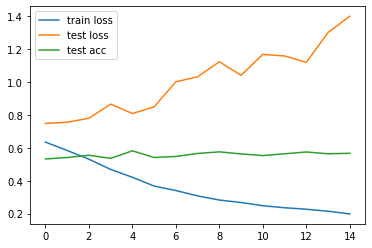

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.plot(test_acc, label='test acc')
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(bert_clf.state_dict(), 'models/mediqa_model_biobert_2')

In [ ]:
# Load model
# model = MEDIQA_Model()
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [25]:
acc, probs, y_pred = get_test_acc(model.to(device), return_probs_and_labels=True)

100%|██████████| 18/18 [01:06<00:00,  3.72s/it]


In [26]:
def get_ranking_predictions(probs, y):
    rankings  = []
    entailed = []
    i_start  = 0
    for i, q in enumerate(QA_test):
        rankings.append(1- np.array(probs[i_start:i_start+len(q.answers)]))
        entailed.append(y[i_start:i_start+len(q.answers)])
        i_start += len(q.answers)
        assert len(rankings[i] == len(QA_test[i].answer_ids))
        assert len(entailed[i] == len(QA_test[i].answers))
    return rankings, entailed

In [32]:
ranking_pred, labels_pred = get_ranking_predictions(probs, y_pred)
QA_test.output_predictions(ranking_pred, labels_pred, file='test_biobert2')

question_id,answer_id,label


In [33]:
evaluate('test_biobert2')

Testing Task (Round-2) : 3
Ground truth: task3/ground_truth_round_2.csv
Submission file: task3/sample_submission_round_2_test_biobert2.csv
{'score_acc': 0.5663956639566395, 'score_secondary_spearman': 0.11690140845070421, 'meta': {'MRR': 0.6255555555555556, 'Precision': 0.6133004926108374}}


In [69]:
bert_clf.eval()
pred_labels = []
bert_clf.to(device)
with torch.no_grad():
    for s,q,a in tqdm.tqdm(test_loader):
        logits = bert_clf(q.to(device),a.to(device))
        pred_labels.extend(logits.to('cpu'))
    pred_labels = np.array([x.item() for x in pred_labels])
    pred = (pred_labels > 0.5).astype(np.int16)
pred

100%|██████████| 35/35 [00:51<00:00,  1.48s/it]


array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [70]:
from sklearn.metrics import accuracy_score

accuracy_score(labels_test, pred)

0.971093044263776

In [38]:
torch.cat([torch.tensor([1,2,3]), torch.tensor([1,2,3])], dim=0)

tensor([1, 2, 3, 1, 2, 3])

In [23]:
torch.tensor([1,2,3]).shape

torch.Size([3])

In [29]:
for b in train_loader:
    print(b)

[tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]]), tensor([[  101,  1293,  1202,  ...,     0,     0,     0],
        [  101,  1169,  1128,  ...,     0,     0,     0],
        [  101, 33869, 31719,  ...,     0,     0,     0],
        ...,
        [  101, 13347,  1104,  ...,     0,     0,     0],
        [  101,  1293,  9987,  ...,     0,     0,     0],
        [  101,  1184,  1110,  ...,     0,     0,     0]]), tensor([[  101, 36256, 27547,  ...,     0,     0,     0],
        [  101, 30460,  3984,  ...,     0,     0,     0],
        [  101,   193,   118,  ...,     0,     0,     0],
        ...,
        [  101,  3073, 10294,  ...,  1110,  1136,  2276],
        [  101,  9987,  1105,  ...,  6059,  1110,  1136],
        [  101, 29193, 16838,  ...,     0,     0,     0]])]
[tensor([[0.],
        [0.],
        [0.],
    

In [277]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

cpu = torch.device('cpu')
cuda = torch.device('cuda')
device = cuda if torch.cuda.is_available() else cpu

model_names = [
    'bert-base-nli-stsb-mean-tokens',
    'bert-large-nli-stsb-mean-tokens',
    'roberta-base-nli-stsb-mean-tokens',
    'roberta-large-nli-stsb-mean-tokens',
    'distilbert-base-nli-stsb-mean-tokens'
]

for name in model_names:
    model = SentenceTransformer(name)
    model = model.to(cuda)

    representations_a = []
    representations_b = []

    with torch.no_grad():
        for (sent_a, sent_b) in tqdm(test_sentences, desc='Embedding Sentences', ncols=800):
            sentences_embeddings = model.encode([sent_a, sent_b])
            representations_a.append(sentences_embeddings[0])
            representations_b.append(sentences_embeddings[1])

    obtained_scores = []
    for idx, (repr_a, repr_b) in enumerate(zip(representations_a, representations_b)):
        score = 1 - cosine(repr_a, repr_b)
        obtained_scores.append(score)

    corr_score = pearsonr(test_scores[:len(obtained_scores)], obtained_scores)[0]
    print(f'{name}: {corr_score}')

100%|██████████| 405M/405M [00:07<00:00, 51.2MB/s] 


AssertionError: Torch not compiled with CUDA enabled

#### BioELMo

https://docs.allennlp.org/v1.0.0rc5/tutorials/how_to/elmo/

https://github.com/allenai/allennlp/blob/main/allennlp/modules/elmo.py

In [1]:
# ! pip install allennlp

In [19]:
import torch
from allennlp.modules.elmo import Elmo, batch_to_ids

In [20]:
# ! pip install allennlp
# ! pip install allennlp-models

In [21]:
cpu = torch.device('cpu')
cuda = torch.device('cuda')
device = cuda if torch.cuda.is_available() else cpu

In [22]:
from allennlp.modules.elmo import Elmo
# elmo = Elmo(
#     options_file='https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway_5.5B/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json', 
#     weight_file='https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway_5.5B/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5',
#     num_output_representations=3,
#     dropout=0
    
# )

bioelmo = Elmo(
    options_file='bioelmo/biomed_elmo_options.json', 
    weight_file='bioelmo/biomed_elmo_weights.hdf5',
    num_output_representations=3,
    dropout=0
)
bioelmo = bioelmo.to(device)

C:\Users\gonre\anaconda3\envs\tf_gpu\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [23]:
sentences = [['First', 'sentence', '.'], ['Another', '.'], ["I", "ate", "a", "carrot", "for", "breakfast"]]
character_ids = batch_to_ids(sentences).to(device)
embeddings = bioelmo(character_ids)
character_ids

tensor([[[259,  71, 106, 115, 116, 117, 260, 261, 261, 261, 261, 261, 261, 261,
          261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
          261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
          261, 261, 261, 261, 261, 261, 261, 261],
         [259, 116, 102, 111, 117, 102, 111, 100, 102, 260, 261, 261, 261, 261,
          261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
          261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
          261, 261, 261, 261, 261, 261, 261, 261],
         [259,  47, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
          261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
          261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,
          261, 261, 261, 261, 261, 261, 261, 261],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   

In [24]:
def get_elmo_embedding(sentence):
    tokens = nltk.word_tokenize(sentence)
#     print(tokens)
    sentences = [tokens]
    character_ids = batch_to_ids(sentences).to(device)
    return bioelmo(character_ids)['elmo_representations'][2].mean(dim=0).mean(dim=0)
    

In [48]:
embeddings['elmo_representations'][0].mean(dim=0).mean(dim=0)

tensor([-0.1981, -0.2493,  0.1472,  ...,  0.0856,  0.0514,  0.0953],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [31]:
K = 0
q = get_elmo_embedding(QA[K].question)
ans = [get_elmo_embedding(a) for a in QA[K].answers]

In [33]:
from scipy.spatial.distance import cosine
print('Label,Rank,Similarity')
for i,a in enumerate(ans):
    sim = 1-cosine(q.detach().cpu(), a.detach().cpu())
    print(QA.labels[K][i], QA.references[K][i], sim)

Label,Rank,Similarity
1 2 0.7145789861679077
0 7 0.6949490308761597
1 3 0.7414701581001282
0 8 0.6276549696922302
1 5 0.7520613670349121
0 6 0.6759256720542908
0 10 0.6990264654159546
1 4 0.740582287311554
0 9 0.6365541219711304
1 1 0.7022466659545898


In [29]:
QA[0].labels

[1, 0, 1, 0, 1, 0, 0, 1, 0, 1]

In [25]:
sentences = [[q.question, a]  for q in QA for a in q.answers]
flatten   = lambda t: [item for sublist in t for item in sublist]
labels    = flatten([q.labels for q in QA])

sentences_test = [[q.question, a]  for q in QA_test for a in q.answers]
labels_test    = flatten([q.labels for q in QA_test]) 

In [26]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

BATCH_SIZE = 8
BATCH_SIZE_TEST = 64
max_len_seq = 512

class MEDIQA_Dataset2(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = []
        self.y = np.array(y)
        for q, a in X:
            _q = batch_to_ids([nltk.word_tokenize(q)])
            _a = batch_to_ids([nltk.word_tokenize(a)])
            self.X.append([_q, _a])
#         self.X = np.array(self.X)
        
    def __len__(self):
#         return self.X.shape[0]
        return len(self.X)
    
    def __getitem__(self, index):
        score = torch.FloatTensor([self.y[index]])
    
        q = torch.LongTensor(self.X[index][0])
        a = torch.LongTensor(self.X[index][1])
        
        return score, q, a

# Create train dataset
train_dataset = MEDIQA_Dataset2(X=sentences, y=labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# Create test dataset
test_dataset = MEDIQA_Dataset2(X=sentences_test, y=labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

In [49]:
import torch.nn as nn
from torch.nn import functional as F

class MEDIQA_Model_bioELMo(nn.Module):
    def __init__(self):
        super(MEDIQA_Model_bioELMo, self).__init__()
        self.bioelmo = Elmo(
            options_file='bioelmo/biomed_elmo_options.json', 
            weight_file='bioelmo/biomed_elmo_weights.hdf5',
            num_output_representations=3,
            dropout=0
        )
        for param in self.bioelmo.parameters():
            param.requires_grad = False
#         self.bioelmo = bioelmo.to(device)
#         modules = [self.bert.embeddings, *self.bert.encoder.layer[:-1]] #Replace 5 by what you want
#         for module in modules:
#             for param in module.parameters():
#                 param.requires_grad = False
        self.linear1 = nn.Linear(2*1024, 128)
        self.linear2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, q, a):
        
#         _, pooled_output = self.bert(tokens, output_all=False)
#         print(q.shape, a.shape)
        q_emb = self.get_elmo_embedding(q)
        a_emb = self.get_elmo_embedding(a)
#         print('CLS:', CLS1.shape, CLS2.shape)
        x = torch.cat([q_emb, a_emb], dim=0)
#         print('concat:', x.shape)
        x = F.dropout(x, 0.2)
        x = self.linear1(x)
        x = nn.LeakyReLU(0.1)(x)
        x = F.dropout(x, 0.1)
        x = self.linear2(x)
        prob = self.sigmoid(x)
        return prob, q_emb, a_emb


    def get_elmo_embedding(self, sentence):
#         tokens = nltk.word_tokenize(sentence)
#     print(tokens)
#         sentences = [tokens]
#         character_ids = batch_to_ids(sentence).to(device)
        return self.bioelmo(sentence)['elmo_representations'][2].mean(dim=0).mean(dim=0)

In [50]:
bioelmo_clf = MEDIQA_Model_bioELMo()
bioelmo_clf = bioelmo_clf.to(device)

In [64]:
from sklearn.metrics import accuracy_score
def get_test_acc(model, return_probs_and_labels=False):
    model.eval()
    pred_probs = []
    with torch.no_grad():
        for s,(q,a) in tqdm.tqdm(zip(test_dataset.y, test_dataset.X)):
            logits, _, _ = model(q.to(device),a.to(device))
            pred_probs.extend(logits.to('cpu'))
        pred_probs  = np.array([x.item() for x in pred_probs])
        pred_labels = (pred_probs > 0.5).astype(np.int16)
    acc = accuracy_score(labels_test, pred_labels)
    if return_probs_and_labels:
        return acc, pred_probs, pred_labels
    else:
        return acc

In [68]:
# Train
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

import tqdm
import random
# bert_clf = MEDIQA_Model()
# bert_clf = bert_clf.to(device)
optimizer = torch.optim.Adam(bioelmo_clf.parameters(), lr=1e-3)
bioelmo_clf.train()
EPOCHS = 100
loss_func = nn.BCELoss()
train_losses, test_losses, test_acc = [], [], []
N = len(train_dataset.y)
for epoch_num in range(EPOCHS):
    losses = []
    
    for step_num, batch_data in enumerate(list(zip(train_dataset.y, train_dataset.X))):
        y_true, (questions, answers) = batch_data #tuple(t.to(device) for t in batch_data)
#         q_e = bioelmo_clf.get_elmo_embedding(questions.to(device))
#         a_e = bioelmo_clf.get_elmo_embedding(answers.to(device))
#         print(q_e)
#         print(a_e)
#         x = torch.cat([q_e, a_e], dim=0)
#         print(y_true)
        logits, _, _ = bioelmo_clf(questions.to(device), answers.to(device))
        y_true = torch.from_numpy(np.array([y_true], dtype=np.float32))
        loss = loss_func(logits, y_true.to(device))
        
        bioelmo_clf.zero_grad()
        loss.backward()
        print(f'step {step_num}/{N}', loss.item(), end="\r")
        losses.append(loss.item())
        optimizer.step()
        del y_true
        del questions
        del answers
        torch.cuda.empty_cache()
    print()
    print(f'Epoch {epoch_num+1}:', np.mean(losses))
    train_losses.append(np.mean(losses))
#     acc = get_test_acc(bioelmo_clf)
    acc, probs_labels, _ = get_test_acc(bioelmo_clf, return_probs_and_labels=True)
    test_acc.append(acc)
    test_loss = loss_func(torch.from_numpy(probs_labels), torch.from_numpy(np.array(labels_test, dtype=np.double))).item()
    test_losses.append(test_loss)
    test_acc.append(acc)
    print(f'Test acc:', acc, '  Test loss:', test_loss)
    print()
    
    if len(test_acc) > 5 and test_acc[-6] > max(test_acc[-5:]):
        print('Early stopping')
        break

0it [00:00, ?it/s]

step 1700/1701 0.5052285194396973
Epoch 1: 0.6197752810447701


1107it [14:22,  1.28it/s]


Test acc: 0.5049683830171635   Test loss: 0.7481869661701842



0it [00:00, ?it/s]

step 1700/1701 0.4131612777709961
Epoch 2: 0.5681940983006284


1107it [14:19,  1.29it/s]


Test acc: 0.5094850948509485   Test loss: 0.7940796232894721



0it [00:00, ?it/s]

step 1700/1701 0.25598791241645813
Epoch 3: 0.5302221145702745


1107it [14:20,  1.29it/s]


Test acc: 0.5212285456187895   Test loss: 0.8184377863532302



0it [00:00, ?it/s]

step 1700/1701 0.11138967424631119
Epoch 4: 0.49645983259108556


1107it [14:16,  1.29it/s]


Test acc: 0.5176151761517616   Test loss: 0.9081658793955999



0it [00:00, ?it/s]

step 1700/1701 0.12534412741661072
Epoch 5: 0.45982026245420327


1107it [14:19,  1.29it/s]


Test acc: 0.5004516711833785   Test loss: 1.0611633258244801



KeyboardInterrupt: 